In [15]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pandas as pd
from typing import NamedTuple, List, Tuple
from IPython.display import display
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# import sys
# Add measurement mcts python package to path
# sys.path.append('../src/measurement_mcts')
# from measurement_mcts.environment.measurement_control_env import MeasurementControlEnvironment
# from measurement_mcts.utils.utils import get_ellipse_scaling
# from measurement_mcts.environment.object_manager import ObjectManager, ObjectTuple

Shape of rects: (4, 4, 2)


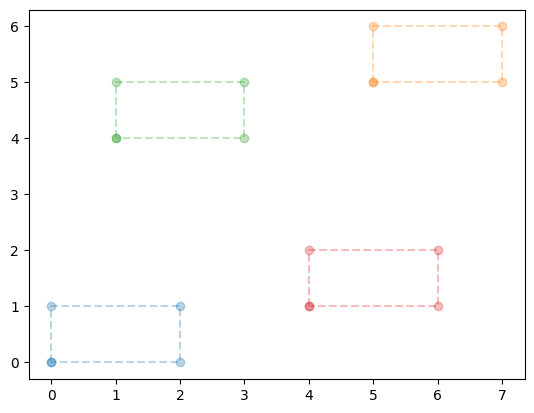

In [20]:
# Create a 4 point rectangle (4,2 points)
rect = np.array([[0, 0], [0, 1], [2, 1], [2, 0]])
rect2 = rect + np.array([5, 5])
rect3 = rect + np.array([1, 4])
rect4 = rect + np.array([4, 1])

rects = np.stack((rect, rect2, rect3, rect4))
print(f'Shape of rects: {rects.shape}')

def plot_rectangles(rects: List[np.ndarray], marker='o--', alpha=0.3):
    for rect in rects:
        rect = np.append(rect, [rect[0]], axis=0)
        plt.plot(rect[:, 0], rect[:, 1], marker, alpha=alpha)

plot_rectangles(rects)

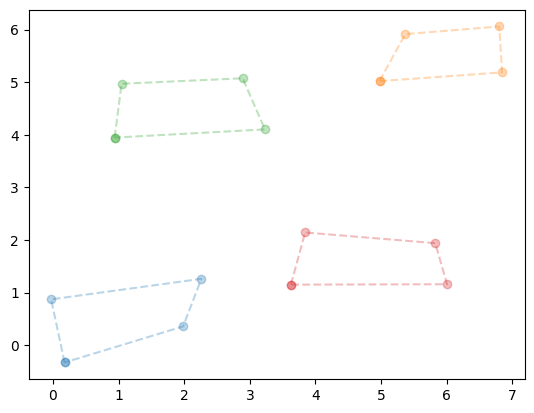

In [38]:
# Add noise to the rectangles
noise = np.random.normal(0, 0.2, rects.shape)
noisy_rects = rects + noise

plot_rectangles(noisy_rects, marker='o--', alpha=0.3)

In [51]:
def corner_data_association(obs_rects: np.ndarray, rects: np.ndarray) -> dict:
    # Create output observation dictionary
    obs_dict = {}
    
    # First calculate centroids of the rectangles
    obs_centroids = np.mean(obs_rects, axis=1)
    centroids = np.mean(rects, axis=1)
    
    # Calculate distance between all pairs of centroids
    distances = cdist(obs_centroids, centroids)
    
    # Solve the assignment problem to find the best match using scipy
    row_ind, col_ind = linear_sum_assignment(distances)
    # print(f'Row indices: {row_ind}')
    # print(f'Column indices: {col_ind}')
    
    # # Organize the rectangles based on the assignment 
    assigned_rects = rects[col_ind]
    # print(f'Assigned rectangles: {assigned_rects}')
    # print(f'Observed rectangles: {obs_rects}')
    
    # Now with objects associated, perform point to point data association
    for i, (obs_rect, maint_rect) in enumerate(zip(obs_rects, assigned_rects)):
        distances = cdist(obs_rect, maint_rect)
        row_idx, col_idx = linear_sum_assignment(distances)
        # print(f'Row indices: {row_idx}')
        # print(f'Column indices: {col_idx}')
        obs_dict[i] = col_idx

    return obs_dict

# Re-arange the noisy rectangles to test data association
noisy_re_arranged_rects = np.stack((noisy_rects[1], noisy_rects[2], noisy_rects[3]))

# Re-arange the points to test data association
noisy_re_arranged_rects = np.stack((noisy_re_arranged_rects[:,1], noisy_re_arranged_rects[:,0], noisy_re_arranged_rects[:,2], noisy_re_arranged_rects[:,3]), axis=1)

obs_dict = corner_data_association(noisy_re_arranged_rects, rects)
print(f'Observation dictionary: {obs_dict}')
    

Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 0
Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 1
Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 2
Observation dictionary: {0: array([1, 0, 2, 3]), 1: array([1, 0, 2, 3]), 2: array([1, 0, 2, 3])}
